# **Model and evaluation Notebook**

## Objectives

- Fit and evaluate a classification model to predict if a patient will suffer from heart disease or not.
- Fulfil business requirement 2.

## Inputs

* outputs/datasets/cleaned/TargetTestSet.csv
* outputs/datasets/cleaned/TargetTrainSet.csv
* outputs/datasets/cleaned/TestSetCleaned.csv
* outputs/datasets/cleaned/TrainSetCleaned.csv

## Outputs

* Data cleaning and Feature Engineering and modeling pipeline
* Feature importance plot
* Heatmap report plot



---

# Set up the Working Directory

Define and confirm the working directory.

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspaces/heart-disease-analysis-and-prediction'

---

# Load data

Here we load the dataset and separate the target variable ('y') from the predictor variable ('X').

In [2]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/heart.csv"))

# Separate predictors and target
X = df.drop(['target'], axis=1)
y = df['target']

print(X.shape)
X.head(3)

(1025, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3


In [ ]:
import numpy as np
import pandas as pd

df = (pd.read_csv("outputs/datasets/cleaned/TargetTestSet.csv"))
df = (pd.read_csv("outputs/datasets/cleaned/TargetTrainSet.csv"))
df = (pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv"))
df = (pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv"))

---

# ML Pipeline

ML Pipeline with Data Cleaning and Feature Engineering already discussed in previous notebooks

In [3]:
from sklearn.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer

def pipeline_transformation():
  pipeline_base = Pipeline([
         ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['age','cp','trestbps','chol','restecg','thalach','oldpeak','slope','ca','thal']) )
  ])

  return pipeline_base

pipeline_transformation()

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['age', 'cp', 'trestbps',
                                                  'chol', 'restecg', 'thalach',
                                                  'oldpeak', 'slope', 'ca',
                                                  'thal']))])

ML Pipeline for Modelling and Hyperparameter Optimisation

In [4]:
from sklearn.preprocessing import StandardScaler # Feat Scaling
from sklearn.feature_selection import SelectFromModel # Feature Selection

def pipeline_clf(model):
  pipeline_base = Pipeline([
       ("scaler",StandardScaler() ),
        ("feature_selection", SelectFromModel(model)),
        ("model", model),
  ])

  return pipeline_base

---

# Hyperparameter Optimisation

The code below is a custom class, used with permission from the Code Institute 'Churnometer' walkthrough project.

In [5]:
from sklearn.model_selection import GridSearchCV
import numpy as np


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = pipeline_clf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

---

# Split Train and Test Set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (820, 13) (820,) 
* Test set: (205, 13) (205,)


Check for duplicates

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Combine train and test data into one DataFrame
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Check for duplicates
duplicates = X_combined.duplicated()
duplicates_exist = duplicates.any()

if duplicates_exist:
    print("Duplicates exist between train and test sets.")
else:
    print("No duplicates found between train and test sets.")

# Print the shapes of train and test sets
print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


Duplicates exist between train and test sets.
* Train set: (820, 13) (820,) 
* Test set: (205, 13) (205,)


Check for the number of duplicates

In [8]:
# Check the number of duplicates in the train set
train_duplicates = X_train[X_train.duplicated(keep='first')]
num_train_duplicates = len(train_duplicates)

# Check the number of duplicates in the test set
test_duplicates = X_test[X_test.duplicated(keep='first')]
num_test_duplicates = len(test_duplicates)

print("Number of duplicates in the train set:", num_train_duplicates)
print("Number of duplicates in the test set:", num_test_duplicates)


Number of duplicates in the train set: 519
Number of duplicates in the test set: 44


### There are duplicates in train and test set:

- Number of duplicates in the train set: 519- Number of duplicates in the test set: 44

Removing duplicates from train and test set

In [9]:
# Remove duplicates from the test set
X_test = X_test.drop_duplicates(keep='first')
y_test = y_test.loc[X_test.index]

# Check the shape of the test set after removing duplicates
print("Test set shape after removing duplicates:", X_test.shape, y_test.shape)


Test set shape after removing duplicates: (161, 13) (161,)


In [10]:
# Remove duplicates from the train set
X_train = X_train.drop_duplicates(keep='first')
y_train = y_train.loc[X_train.index]

# Check the shape of the train set after removing duplicates
print("Train set shape after removing duplicates:", X_train.shape, y_train.shape)

Train set shape after removing duplicates: (301, 13) (301,)


---

# Grid Search for classification

The following steps will identify the best Model and Hyperparameters to train the model

In [11]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [12]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,XGBClassifier,0.666667,0.751587,0.857143,0.074566
3,GradientBoostingClassifier,0.666667,0.737037,0.785714,0.043618
4,ExtraTreesClassifier,0.62963,0.735979,0.892857,0.090492
2,RandomForestClassifier,0.62963,0.722222,0.821429,0.06892
1,DecisionTreeClassifier,0.62963,0.700794,0.777778,0.048322
5,AdaBoostClassifier,0.555556,0.677778,0.857143,0.098566


Based on the grid result the three best model with a mean score of maximum 0.75 were:

- XGBClassifier with 0.75 mean score
- GradientBoostingClassifier with 0.73 mean score
- ExtraTreesClassifier with 0.73 mean score

---

## Notes on performance

Main issue with the model and performance , was a performance and accuracy of 100 %. To resolve this issue developer tried different approaches.

First approach:
- Developer checked that split of train and test set for issues, thinking the issue was data leakage.
- Reload all sets , and tried to check for leaked data.
- Issue was not solved.

Second approach:
- Developer found out that the main issue was the duplicates in the train and test set that were bringing the accuracy to 100 %.
- Developer tried to eliminate just the duplicates from the test set.
- Issue was not solved .

Third approach:
- To eliminate the duplicates from the test set and the train set.
- The performance gave a result of 0.85 % resolving the 100 % issue.
- Issue was solved.

---

# Extensive search on the most suitable model to find the best hyperparameter configuration.

In [14]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier


models_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}


params_search = {
    "XGBClassifier": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
    },
    "GradientBoostingClassifier": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
    },
    "ExtraTreesClassifier": {
        "model__n_estimators": [20],
        "model__max_depth": [5],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1],
    }
}


Extensive GridSearch CV

In [15]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(5)

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators,model__min_samples_leaf,model__min_samples_split
2,XGBClassifier,0.848485,0.902652,0.9375,0.029233,0.01,3,200,NaN,NaN
1,XGBClassifier,0.848485,0.902652,0.9375,0.029233,0.01,3,100,NaN,NaN
54,ExtraTreesClassifier,0.875,0.902273,0.939394,0.023521,NaN,5,20,1,2
7,XGBClassifier,0.848485,0.896591,0.9375,0.030388,0.01,5,100,NaN,NaN
3,XGBClassifier,0.848485,0.896591,0.9375,0.030388,0.01,4,50,NaN,NaN


From the summary above we note that the 2 best models are XGBClassifier and ExtraTreesClassifier.

Getting the best model

In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBClassifier'

XGBClassifier has been chosen as the best model.
Choosing the best Hyperparameter as well

In [18]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Get the complete pipeline of the best model, including all preprocessing steps and the estimator itself, with the parameters set to their optimal values:

In [19]:
best_classification_pipeline = grid_search_pipelines[best_model].best_estimator_
best_classification_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         grow_policy=None,
                                                         import...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

---

# Feature inportance

In [20]:
X_train.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
315,42,1,3,148,244,0,0,178,0,0.8,2,2,2
204,66,0,2,146,278,0,0,152,0,0.0,1,1,2
363,53,1,2,130,246,1,0,173,0,0.0,2,3,2


* These are the 3 most important features in descending order. The model was trained on them: 
['cp', 'ca', 'thal']


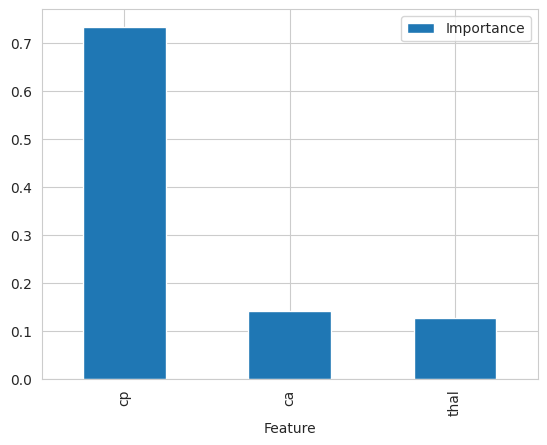

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[best_classification_pipeline['feature_selection'].get_support()],
    'Importance': best_classification_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Most important features:

- **cp** 0,75
- **ca** and **thal** 0.20.

---

# Evaluate pipeline

In [22]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [23]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=best_classification_pipeline,
                label_map= ['No disease', 'Disease'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No disease Actual Disease
Prediction No disease               104             15
Prediction Disease                   33            149


---  Classification Report  ---
              precision    recall  f1-score   support

  No disease       0.87      0.76      0.81       137
     Disease       0.82      0.91      0.86       164

    accuracy                           0.84       301
   macro avg       0.85      0.83      0.84       301
weighted avg       0.84      0.84      0.84       301
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No disease Actual Disease
Prediction No disease                57              6
Prediction Disease                   18             80


---  Classification Report  ---
              precision    recall  f1-score   support

  No disease       0.90      0.76      0.83        75
     Disease       0.82      0.93      0.87        86

    accuracy 

## Confusion matrix results

Train set: 

- The report for the no disease is higher with a precision of the 0.87 and recall of 0.76.
- The report for the disease lower with a precision of the 0.82 and recall of 0.91.
- Mean accuracy of 0.84

Test set: 

- The Report for the no disease is higher with a precision of the 0.90 and recall of 0.76.
- The report for the disease lower with a precision of the 0.82 and recall of 0.93.
- Mean accuracy of 0.85

## We create a new pipeline, using the best model and the best hyperparameters from the research above.

In [24]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def xgbclassifier_pipeline():
    # Define the hyperparameters
    hyperparameters = {
        'learning_rate': 0.01,
        'max_depth': 3,
        'n_estimators': 100
    }

    model = XGBClassifier(**hyperparameters)

    pipeline_base = Pipeline([
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['age','cp','trestbps','chol','restecg','thalach','oldpeak','slope','ca','thal'])),
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(estimator=model)),
        ('model', model)
    ])

    return pipeline_base

# Create the XGBoost pipeline with hyperparameters
xgb_pipeline = xgbclassifier_pipeline()
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['age', 'cp', 'trestbps',
                                                  'chol', 'restecg', 'thalach',
                                                  'oldpeak', 'slope', 'ca',
                                                  'thal'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=No...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_true=xgb_pipeline.predict(X_test), y_pred=y_test)

array([[57,  5],
       [18, 81]])

In [26]:
print(classification_report(y_pred=xgb_pipeline.predict(X_test), y_true=y_test))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83        75
           1       0.82      0.94      0.88        86

    accuracy                           0.86       161
   macro avg       0.87      0.85      0.85       161
weighted avg       0.87      0.86      0.86       161



#### Plot the classification report using a heatmap

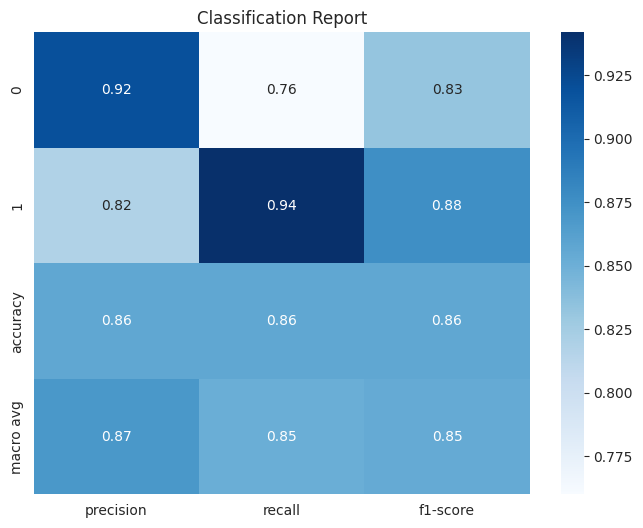

In [27]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
report = classification_report(y_pred=xgb_pipeline.predict(X_test), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report')
plt.show()


From the heatmap and the report we can see that:

- the precision for class 0 is 0.92
- the precision for class 1 is 0.82
- the recall for class 0 is 0.75
- the recall for class 1 is 0.94
- accuracy of 0.86

---

#  Refit pipeline with best features

## Rewrite ml pipeline using best models, hyperparameters and features

In [ ]:
best_features

## Split train and test set using just best features

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

Remove again duplicates from test set

In [ ]:
# Remove duplicates from the test set
X_test = X_test.drop_duplicates(keep='first')
y_test = y_test.loc[X_test.index]

# Check the shape of the test set after removing duplicates
print("Test set shape after removing duplicates:", X_test.shape, y_test.shape)


Remove again duplicates from train set

In [ ]:
# Remove duplicates from the train set
X_train = X_train.drop_duplicates(keep='first')
y_train = y_train.loc[X_train.index]

# Check the shape of the train set after removing duplicates
print("Train set shape after removing duplicates:", X_train.shape, y_train.shape)

## Filtering best features

In [ ]:
X_train.head(3)

In [ ]:
best_features

In [ ]:
X_train_filtered = X_train.filter(best_features)
X_test_filtered = X_test.filter(best_features)

print(X_train_filtered.shape, y_train.shape, X_test_filtered.shape, y_test.shape)

In [ ]:
X_train_filtered.head(3)

---

# Reaxamine performance of the pipeline

In [ ]:
from xgboost import XGBClassifier
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def xgbclassifier_pipeline_1():
    # Define the hyperparameters
    hyperparameters = {
        'learning_rate': 0.01,
        'max_depth': 3,
        'n_estimators': 100
    }

    model = XGBClassifier(**hyperparameters)

    pipeline_base = Pipeline([
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['ca', 'cp', 'thal'])),
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(estimator=model)),
        ('model', model)
    ])

    return pipeline_base

# Create the XGBoost pipeline with hyperparameters
xgb_pipeline_1 = xgbclassifier_pipeline_1()
xgb_pipeline_1.fit(X_train_filtered, y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report_1(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train_filtered, y_train, X_test_filtered, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train_filtered, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test_filtered, y_test, pipeline, label_map)

In [ ]:
print(classification_report(y_pred=xgb_pipeline_1.predict(X_test_filtered), y_true=y_test))

Heatmap for classification report

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
report = classification_report(y_pred=xgb_pipeline_1.predict(X_test_filtered), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report 1')
plt.show()

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'
# Define the filename for this plot
plot_filename_classification_report_1 = f'{file_path}/classification_report_1.png'

# Set up the saving parameters (ensure no actual saving happens in this section)
plt.ioff()


After training model just on best features the performance of both sets dropped of 10%.

Developer decided to not use these combination of features.

---

# Trying to refit pipeline with features Selection from previous notebook

Redefine best features

In [ ]:
best_correlation_features = ['ca', 'cp', 'exang', 'oldpeak', 'thalach', 'chol']
best_correlation_features

Filter again the train and test set with best features

In [ ]:
X_train_filtered_2 = X_train.filter(best_correlation_features)
X_test_filtered_2 = X_test.filter(best_correlation_features)

In [ ]:
print(X_train_filtered_2.shape, y_train.shape, X_test_filtered_2.shape, y_test.shape)
X_train_filtered_2.head(3)

# Reaxamine performance of the pipeline

In [ ]:
from xgboost import XGBClassifier
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def xgbclassifier_pipeline_2():
    # Define the hyperparameters
    hyperparameters = {
        'learning_rate': 0.01,
        'max_depth': 3,
        'n_estimators': 100
    }

    model = XGBClassifier(**hyperparameters)

    pipeline_base = Pipeline([
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['ca', 'cp', 'exang', 'oldpeak', 'thalach', 'chol'])),
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(estimator=model)),
        ('model', model)
    ])

    return pipeline_base

# Create the XGBoost pipeline with hyperparameters
xgb_pipeline_2 = xgbclassifier_pipeline_2()
xgb_pipeline_2.fit(X_train_filtered_2, y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train_filtered_2, y_train, X_test_filtered_2, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train_filtered_2, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test_filtered_2, y_test, pipeline, label_map)

Confusion matrix report

In [ ]:
print(classification_report(y_pred=xgb_pipeline_2.predict(X_test_filtered_2), y_true=y_test))

Heatmap for classification report

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
report = classification_report(y_pred=xgb_pipeline_2.predict(X_test_filtered_2), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report 2')

# Display the plot
plt.show()

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'
# Define the filename for this plot
plot_filename_classification_report_2 = f'{file_path}/classification_report_2.png'

# Set up the saving parameters (ensure no actual saving happens in this section)
plt.ioff()


Performance report:

- the precision for class 0 is 0.73
- the precision for class 1 is 0.78
- the recall for class 0 is 0.76
- the recall for class 1 is 0.76
- accuracy of 0.76

Conclusions:

- Again the developer found that this combination of features does not bring higher or relative equal performance to the one with all features.
- Performance dropped from an accuracy of 0.86 to 0.76.
- The test and train set will be saved already filtered without duplicates to be used in next notebook.
- Pipeline will be saved to try in next notebook different combination of features.

# Save and push file to repo

We will generate the following files:

- Train set without duplicates
- Test set without duplicates
- Data cleaning and Feature Engineering and modeling pipeline with 3 features
- Data cleaning and Feature Engineering and modeling pipeline with 6 features
- First heatmap plot
- Second heatmap plot

In [ ]:
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train = X_train_filtered
X_test = X_test_filtered

X_train.head(3)

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test set

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Save First pipeline with three features

In [ ]:
xgbclassifier_pipeline_1 = xgb_pipeline_1
xgbclassifier_pipeline_1

In [ ]:
import joblib

joblib.dump(value=xgbclassifier_pipeline_1,
            filename=f"{file_path}/xgbclassifier_pipeline_1.pkl")

## Save plot showing feature importance

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/best_3_features_importance.png', bbox_inches='tight')

## Save heatmap report on performance

In [ ]:
# Generate classification report
report = classification_report(y_pred=xgb_pipeline_1.predict(X_test_filtered), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report 1')

# Save the plot to the specified filename
plt.savefig(plot_filename_classification_report_1, bbox_inches='tight')

# Display the saved plot
plt.show()


# Saving second version pipeline

In [ ]:
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train set

In [ ]:
X_train = X_train_filtered_2
X_test = X_test_filtered_2

X_train.head(3)

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test set

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Save second pipeline with correlation features

In [ ]:
xgbclassifier_pipeline_2 = xgb_pipeline_2
xgbclassifier_pipeline_2

In [ ]:
import joblib

joblib.dump(value=xgbclassifier_pipeline_2,
            filename=f"{file_path}/xgbclassifier_pipeline_2.pkl")

## Save heatmap report on performance

In [ ]:
# Generate classification report
report = classification_report(y_pred=xgb_pipeline_2.predict(X_test_filtered_2), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report 2')

# Save the plot to the specified filename
plt.savefig(plot_filename_classification_report_2, bbox_inches='tight')

# Display the saved plot
plt.show()
